### Imports

In [1]:
import gc
import time
import os

import numpy as np
from matplotlib import pyplot as plt

import mne

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.test.gpu_device_name()

''

## Preprocessing

### Loading edf

In [4]:
edfs_path = "..\dataverse_files"

In [5]:
def load_patients_data(edfs_path):
    raw_patients_data = []
    
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]
    
    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

In [6]:
raw_patients_data = load_patients_data(edfs_path)

### Filtered EEG signals segmentation

In [7]:
def get_label(edf):
    patient_edf_file_name = edf.filenames[0].split('\\')[-1]
    isSick = patient_edf_file_name.lower().startswith('s')
    return int(isSick == True) # 1 - is sick, 0 is healthy

In [8]:
def print_info(epochs_num_per_patient, labels):
    print('\nEpochs number per patient: ', epochs_num_per_patient)
    
    class_0_num = sum(labels) 
    class_1_num = len(labels)-sum(labels)

    print('\nnegative: ', class_0_num)
    print('positive: ', class_1_num)

In [9]:
def transform_patients_data_into_X_y_sets(patients_data, info=True):
    epochs_per_patient = []
    labels = []
    
    epochs_num_per_patient = []
    for edf in raw_patients_data:
        epochs = mne.make_fixed_length_epochs(edf, duration=5.0, preload=True, verbose=False)
        epochs_per_patient.append(epochs)
        epochs_num_per_patient.append(len(epochs))
        
        label = get_label(edf)
        labels.extend([label for epoch in epochs])
    
    epochs = mne.concatenate_epochs(epochs_per_patient)

    if info:
        print_info(epochs_num_per_patient, labels)
        
    del epochs_num_per_patient
    gc.collect()
    
    return (epochs, np.array(labels)) # (X, y)

In [10]:
X, y = transform_patients_data_into_X_y_sets(raw_patients_data)
del raw_patients_data
gc.collect()

Not setting metadata
5771 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [185, 182, 182, 185, 189, 186, 182, 182, 181, 223, 183, 180, 193, 173, 169, 229, 192, 241, 178, 148, 269, 182, 237, 170, 272, 217, 227, 434]

negative:  3165
positive:  2606


0

In [11]:
print(len(y))
print(len(X))
print(X[0].get_data().shape)

5771
5771
(1, 19, 1250)


In [12]:
X.to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


### Feature Extraction (Variance)

In [13]:
np.set_printoptions(precision=50)

In [14]:
for epoch in X:
    print (epoch.shape)
    break

(19, 1250)


In [15]:
Input_N = X[0].get_data().shape[1] # input layer neurons number
print('Input_N: ', Input_N)

Output_N = 2 # classes: sick/positive = 1, not sick/negative = 0 // len(np.unique(y))
print('Output_N: ', Output_N)

Hidden_N = int(np.sqrt(Input_N*Output_N)) # neurons in hidden layer
print('Hidden_N: ', Hidden_N)

Input_N:  19
Output_N:  2
Hidden_N:  6


In [16]:
# Calculating energy for signal segments
# X = np.array([[np.sqrt(statistics.variance(channel_data)) for channel_data in epoch] for epoch in X])
X = np.array([[np.sqrt(np.var(channel_data)) for channel_data in epoch] for epoch in X])

# X = np.array([[np.var(channel_data) for channel_data in epoch] for epoch in X])

In [17]:
print(np.max(X))
print(np.min(X))

0.0019119929414324517
2.0679515313825692e-25


In [18]:
min_max_range = (0,1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [19]:
print(np.max(X))
print(np.min(X))

1.0000000000000002
0.0


In [20]:
X.shape

(5771, 19)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=1)

In [22]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (4905, 19)
y_train:  (4905,)
X_test:  (866, 19)
y_test:  (866,)


# MLP with Keras - binary cross entropy

In [23]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [25]:
def test_model_raw_data(X_test, y_test, model, save_path = ''):
    predictions = model.predict(X_test, verbose=0)

    predictions = [0 if x < 0.5 else 1 for x in predictions]

    accuracy = accuracy_score(y_test, predictions)
    print("Test Accuracy:", accuracy)
    
    f1score = f1_score(y_test, predictions)
    print("F1 score:", f1score)
    
    ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    
    to_file = len(save_path) > 0
    
    if to_file:
        plt.savefig(f'{save_path}/{model.name}-confussion-matrix.png', facecolor='white', transparent=False, dpi=500)
    
    RocCurveDisplay.from_predictions(y_test, predictions)
    
    if to_file:
        plt.savefig(f'{save_path}/{model.name}-roc-curve.png', facecolor='white', transparent=False, dpi=500)
    

In [26]:
# Input shape
input_shape = (Input_N,)

model = Sequential()

model.add(Dense(100, input_shape=input_shape, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [27]:
opt = Adam(learning_rate=0.001)

In [28]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                           patience=15,
                           restore_best_weights=True,
                           mode='max', 
                           verbose=1)

In [29]:
# Hyperparameters and training
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(
    X_train, 
    y_train, 
    epochs=300, 
    batch_size=32, 
    verbose=1, 
    validation_split=0.2,
    callbacks=[early_stopping])

Epoch 1/300
123/123 [==============================] - 1s 2ms/step - loss: 0.6842 - accuracy: 0.5487 - val_loss: 0.6797 - val_accuracy: 0.5474
Epoch 2/300
123/123 [==============================] - 0s 1ms/step - loss: 0.6736 - accuracy: 0.5489 - val_loss: 0.6666 - val_accuracy: 0.5474
Epoch 3/300
123/123 [==============================] - 0s 1ms/step - loss: 0.6590 - accuracy: 0.6050 - val_loss: 0.6508 - val_accuracy: 0.5780
Epoch 4/300
123/123 [==============================] - 0s 1ms/step - loss: 0.6416 - accuracy: 0.6583 - val_loss: 0.6349 - val_accuracy: 0.6504
Epoch 5/300
123/123 [==============================] - 0s 1ms/step - loss: 0.6263 - accuracy: 0.6830 - val_loss: 0.6207 - val_accuracy: 0.6656
Epoch 6/300
123/123 [==============================] - 0s 1ms/step - loss: 0.6125 - accuracy: 0.6980 - val_loss: 0.6085 - val_accuracy: 0.6595
Epoch 7/300
123/123 [==============================] - 0s 1ms/step - loss: 0.6007 - accuracy: 0.6972 - val_loss: 0.5971 - val_accuracy: 0.6809

Epoch 58/300
123/123 [==============================] - 0s 1ms/step - loss: 0.3426 - accuracy: 0.8805 - val_loss: 0.3500 - val_accuracy: 0.8624
Epoch 59/300
123/123 [==============================] - 0s 1ms/step - loss: 0.3403 - accuracy: 0.8810 - val_loss: 0.3470 - val_accuracy: 0.8695
Epoch 60/300
123/123 [==============================] - 0s 1ms/step - loss: 0.3391 - accuracy: 0.8846 - val_loss: 0.3509 - val_accuracy: 0.8777
Epoch 61/300
123/123 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8795 - val_loss: 0.3480 - val_accuracy: 0.8644
Epoch 62/300
123/123 [==============================] - 0s 1ms/step - loss: 0.3349 - accuracy: 0.8848 - val_loss: 0.3426 - val_accuracy: 0.8726
Epoch 63/300
123/123 [==============================] - 0s 2ms/step - loss: 0.3348 - accuracy: 0.8856 - val_loss: 0.3433 - val_accuracy: 0.8665
Epoch 64/300
123/123 [==============================] - 0s 1ms/step - loss: 0.3334 - accuracy: 0.8818 - val_loss: 0.3419 - val_accuracy:

Epoch 115/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2917 - accuracy: 0.9034 - val_loss: 0.3157 - val_accuracy: 0.9052
Epoch 116/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2914 - accuracy: 0.8983 - val_loss: 0.3135 - val_accuracy: 0.9011
Epoch 117/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2890 - accuracy: 0.9006 - val_loss: 0.3127 - val_accuracy: 0.9011
Epoch 118/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2896 - accuracy: 0.9004 - val_loss: 0.3190 - val_accuracy: 0.8940
Epoch 119/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2902 - accuracy: 0.9006 - val_loss: 0.3106 - val_accuracy: 0.9011
Epoch 120/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2879 - accuracy: 0.9021 - val_loss: 0.3148 - val_accuracy: 0.9011
Epoch 121/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2870 - accuracy: 0.9024 - val_loss: 0.3126 - val_ac

123/123 [==============================] - 0s 1ms/step - loss: 0.2595 - accuracy: 0.9139 - val_loss: 0.3006 - val_accuracy: 0.9113
Epoch 172/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2587 - accuracy: 0.9149 - val_loss: 0.3017 - val_accuracy: 0.9103
Epoch 173/300
123/123 [==============================] - 0s 1ms/step - loss: 0.2569 - accuracy: 0.9116 - val_loss: 0.3008 - val_accuracy: 0.9103
Epoch 173: early stopping


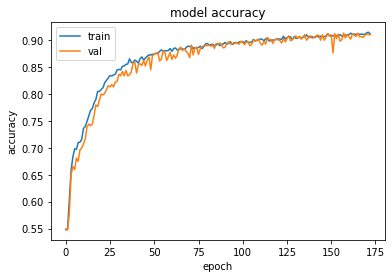

In [30]:
plot_accuracy(history)

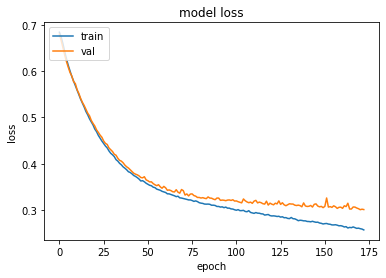

In [31]:
plot_loss(history)

Test Accuracy: 0.9041570438799076
F1 score: 0.9108485499462943


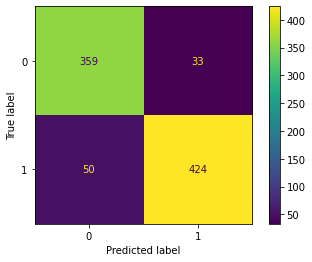

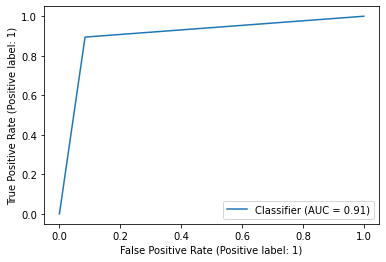

In [32]:
test_model_raw_data(X_test, y_test, model)

### Sklearn MLP Classifier

Iteration 1, loss = 0.68532986
Validation score: 0.548420
Iteration 2, loss = 0.67887895
Validation score: 0.548420
Iteration 3, loss = 0.67020986
Validation score: 0.547401
Iteration 4, loss = 0.66008826
Validation score: 0.545362
Iteration 5, loss = 0.64802036
Validation score: 0.668705
Iteration 6, loss = 0.63532936
Validation score: 0.666667
Iteration 7, loss = 0.62313301
Validation score: 0.673802
Iteration 8, loss = 0.61135437
Validation score: 0.681957
Iteration 9, loss = 0.60175192
Validation score: 0.676860
Iteration 10, loss = 0.59222206
Validation score: 0.682977
Iteration 11, loss = 0.58273130
Validation score: 0.693170
Iteration 12, loss = 0.57474924
Validation score: 0.701325
Iteration 13, loss = 0.56735169
Validation score: 0.710499
Iteration 14, loss = 0.55921348
Validation score: 0.696228
Iteration 15, loss = 0.55292431
Validation score: 0.722732
Iteration 16, loss = 0.54467789
Validation score: 0.721713
Iteration 17, loss = 0.53782286
Validation score: 0.737003
Iterat

Iteration 141, loss = 0.30116043
Validation score: 0.873598
Iteration 142, loss = 0.29901183
Validation score: 0.872579
Iteration 143, loss = 0.29799493
Validation score: 0.872579
Iteration 144, loss = 0.29907598
Validation score: 0.873598
Iteration 145, loss = 0.29860874
Validation score: 0.863405
Iteration 146, loss = 0.29795822
Validation score: 0.877676
Iteration 147, loss = 0.29644039
Validation score: 0.871560
Iteration 148, loss = 0.29699322
Validation score: 0.878695
Iteration 149, loss = 0.29767684
Validation score: 0.874618
Iteration 150, loss = 0.29625345
Validation score: 0.878695
Iteration 151, loss = 0.29456578
Validation score: 0.872579
Iteration 152, loss = 0.29605105
Validation score: 0.879715
Validation score did not improve more than tol=0.000100 for 15 consecutive epochs. Stopping.
F1 Score: 0.8917470525187567
ACC: 0.8833718244803695


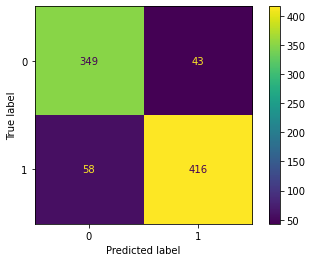

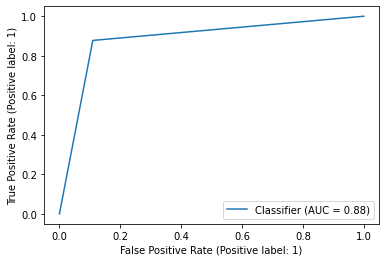

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1337, max_iter=300, early_stopping=True, batch_size=32,
                    validation_fraction=0.2, n_iter_no_change=15, verbose=1).fit(X_train, y_train)

y_pred = clf.predict(X_test)
res_f1_score = f1_score(y_test, y_pred)
res_acc = clf.score(X_test, y_test)

print(f"F1 Score: {res_f1_score}")
print(f"ACC: {res_acc}")


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

RocCurveDisplay.from_predictions(y_test, y_pred)


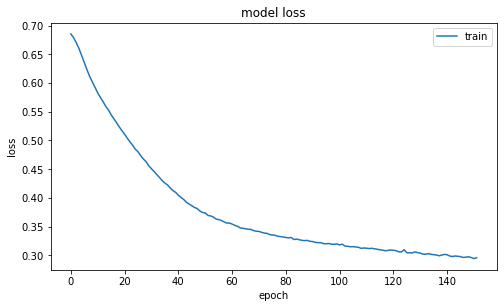

In [37]:
plt.figure(figsize=(8,10))

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(clf.loss_curve_)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
clf.get_params()